In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import os
import sys
sys.path.append('../..//scripts')
import landcover_definitions as lc
import util

In [2]:
torchgeo_pred_dir = '../../../torchgeo_predictions_rep'
torchgeo_data_dir = '/torchgeo_data'

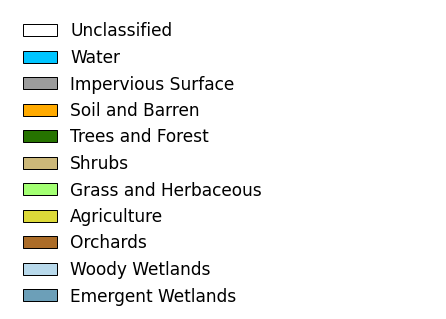

In [3]:
lc.make_legend_figure('enviroatlas')

In [4]:
classes_keep = [1,2,3,4,6]

def reindex_ea(array_in, classes_keep):
    ignore_index = len(classes_keep)
    reindex_map = dict(zip(classes_keep, np.arange(len(classes_keep))))
    # reindex shrub to tree
    tree_idx = 3 # tree idx is 3 when there are no zeros
    shrub_idx = 5
    reindexed_mask = -1 * np.ones(array_in.shape)
    for old_idx, new_idx in reindex_map.items():
        reindexed_mask[array_in == old_idx] = new_idx

    reindexed_mask[reindexed_mask == -1] = ignore_index

    return reindexed_mask

colors = [lc.lc_colors['enviroatlas'][c] for c in classes_keep]

10


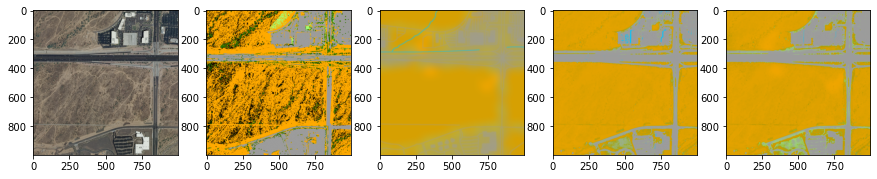

10


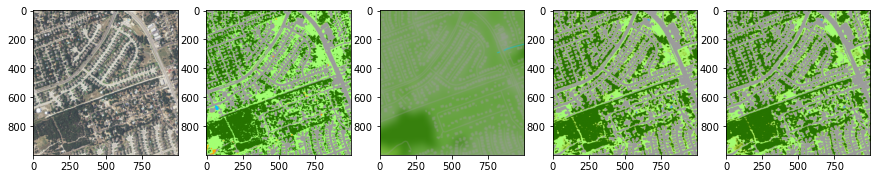

10


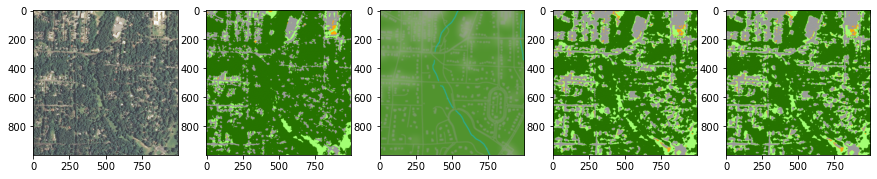

10


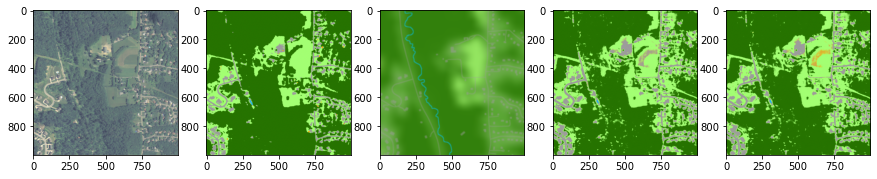

In [6]:
set_this = 'test'
results_by_state_q = {}
results_by_state_r = {}

states_to_eval = ['phoenix_az-2010_1m',
                  'austin_tx-2012_1m',
                  'durham_nc-2012_1m', 
                  'pittsburgh_pa-2010_1m'
                ]

loss_to_eval_options = [
    'qr_forward',
 #   'qr_reverse',
#    'ce'
]

prior_version = 'from_cooccurrences_101_31'
prior_name = f'prior_{prior_version}'
p_add_smooth = 1e-4

for state in states_to_eval:
    results_by_state_q[state] = {}
    results_by_state_r[state] = {}
    
    for loss in loss_to_eval_options:
  #  for loss in [1]:
        data_dir = f'{torchgeo_data_dir}/enviroatlas_lotp'
        data_dir_this_set = os.path.join(data_dir,f'{state}-{set_this}_tiles-debuffered')
        
        # uncomment to pick which to show
        
      # 1. qr from pa checkpoint
#         run_name = f'pa_checkpoint_{state}_fcn_1e-05_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001'
#         compute_r = True
        
#         # 2. qr from scratch
        compute_r = True
        if loss == 'qr_forward':
            run_name = f'{state}_fcn_1e-05_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001'
        elif loss == 'qr_reverse':
            run_name = f'{state}_fcn_0.001_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001'
        
        
        # 3. highres with prior as input
#         run_name = f'pittsburgh_pa-2010_1m_fcn_0.0001_ce_with_prior'
#         compute_r = False
        
        # 4. highres without prior as input
   #     run_name = f'pittsburgh_pa-2010_1m_fcn_0.001_nll'
   #     compute_r = False
    
        # 5. output from learned priors
#         prior_version = 'learned_101_31'
#         prior_name = f'prior_{prior_version}'

#         run_name = f'pa_checkpoint_{state}_fcn_1e-05_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001'
#         compute_r = True
        
        
        pred_dir = f'{torchgeo_pred_dir}/{run_name}/enviroatlas_lotp'
        pred_dir_this_set = os.path.join(pred_dir,f'{state}-{set_this}_tiles-debuffered')

        fns = os.listdir(data_dir_this_set)
        tile_ids = np.unique([x[:10] for x in fns])
        print(len(tile_ids))

        for tile_id in tile_ids[:1]:
        #or tile_id in tile_ids[:1]:
            fn_this = os.path.join(data_dir_this_set, f'{tile_id}_h_highres_labels.tif')
            pred_fn_this = os.path.join(pred_dir_this_set, f'{tile_id}_{loss}_pred_last.tif')
            t1 = time.time()

            
            # gather the data
            with rasterio.open(fn_this.replace('h_highres_labels', 'a_naip')) as f:
                img_this = f.read()
            with rasterio.open(fn_this) as f:
                hr_lc = f.read()[0]
            # reindex
            hr_lc = reindex_ea(lc.map_raw_lc_to_idx['enviroatlas'][hr_lc], classes_keep)

            preds_this_soft = rasterio.open(pred_fn_this).read()
            
            h1, h2 = 1000,2000
            w1, w2 = 1000,2000
            # now do r
            
            if compute_r:
                prior_this = rasterio.open(fn_this.replace('h_highres_labels.tif',f'{prior_name}.tif')).read()

                prior = (prior_this / 255. + p_add_smooth) / (prior_this / 255. + p_add_smooth).sum(axis=0)

                z = (preds_this_soft.T / preds_this_soft.sum(axis=(1,2)) ).T
                preds_r_soft = (prior*z)/(prior*z).sum(axis=0)

                fig, ax = plt.subplots(1,5,figsize=(15,3))
                ax[0].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
                ax[1].imshow(lc.vis_lc_from_colors(hr_lc[h1:h2,w1:w2], colors).T.swapaxes(0,1))
                ax[2].imshow(lc.vis_lc_from_colors(prior[:,h1:h2,w1:w2], colors).T.swapaxes(0,1))
                ax[3].imshow(lc.vis_lc_from_colors(preds_this_soft[:,h1:h2,w1:w2], colors).T.swapaxes(0,1))
                ax[4].imshow(lc.vis_lc_from_colors(preds_r_soft[:,h1:h2,w1:w2], colors).T.swapaxes(0,1))
                plt.show()
                
            else:
                fig, ax = plt.subplots(1,3,figsize=(15,3))
                ax[0].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
                ax[1].imshow(lc.vis_lc_from_colors(hr_lc[h1:h2,w1:w2], colors).T.swapaxes(0,1))
                ax[2].imshow(lc.vis_lc_from_colors(preds_this_soft[:,h1:h2,w1:w2], colors).T.swapaxes(0,1))
                plt.show()